# Steup

## 1- Ray

We'll be using Ray to scale and productionize our ML application. Ray consists of a core distributed runtime along with libraries for scaling ML workloads and has companies like OpenAI, Spotify, Netflix, Instacart, Doordash + many more using it to develop their ML applications. We're going to start by initializing Ray inside our notebooks:

In [233]:
import ray

In [234]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init(num_cpus = 4, num_gpus=1)
# ray.init(num_cpus = 6, num_gpus=1, object_store_memory = 7 * 1024 * 1024 * 1024)

2023-11-23 10:44:33,240	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


### Prometheus dashboard

folder : 
madewithml\venv\Lib\site-packages\ray\dashboard\modules\metrics\export\prometheus

C:\Users\Youness\Desktop\MLOPS\prometheus\prometheus --config.file=C:\Users\Youness\Desktop\MLOPS\madewithml\venv\Lib\site-packages\ray\dashboard\modules\metrics\export\prometheus\prometheus.yml

http://localhost:9090

view our cluster resources to view the available compute resources

In [235]:
ray.cluster_resources()

{'GPU': 1.0,
 'CPU': 4.0,
 'node:172.24.97.175': 1.0,
 'memory': 5396358759.0,
 'object_store_memory': 2698179379.0,
 'node:__internal_head__': 1.0}

In [236]:
# Deffine workers
num_workers = 1
resources_per_worker={"CPU": 3, "GPU": 1}

# DATA

## 1- Data Ingestion

In [55]:
import pandas as pd

In [56]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


## 2- Splitting

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [59]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [60]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [61]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## 3- Exploratory Data Analysis (EDA)

In [62]:
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

import warnings; warnings.filterwarnings("ignore")

from wordcloud import WordCloud, STOPWORDS

### 3.1 - Tag distribution

How many data points do we have per tag? We'll use the Counter class to get counts for all the different tags.

In [63]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

We can then separate the tags and from their respective counts and plot them using Plotly.

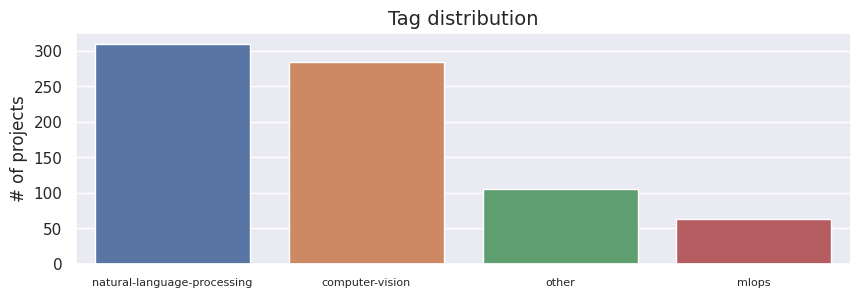

In [64]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())

plt.figure(figsize=(10, 3))

ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)

plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

We do have some data imbalance but it's not too bad. If we did want to account for this, there are many strategies, including over-sampling less frequent classes and under-sampling popular classes, class weights in the loss function, etc.

### 3.2 WordCloud

Is there enough signal in the title and description that's unique to each tag? This is important to know because we want to verify our initial hypothesis that the project's title and description are high quality features for predicting the tag. And to visualize this, we're going to use a wordcloud. We also use a jupyter widget, which you can view in the notebook, to interactively select a tag and see the wordcloud for that tag.

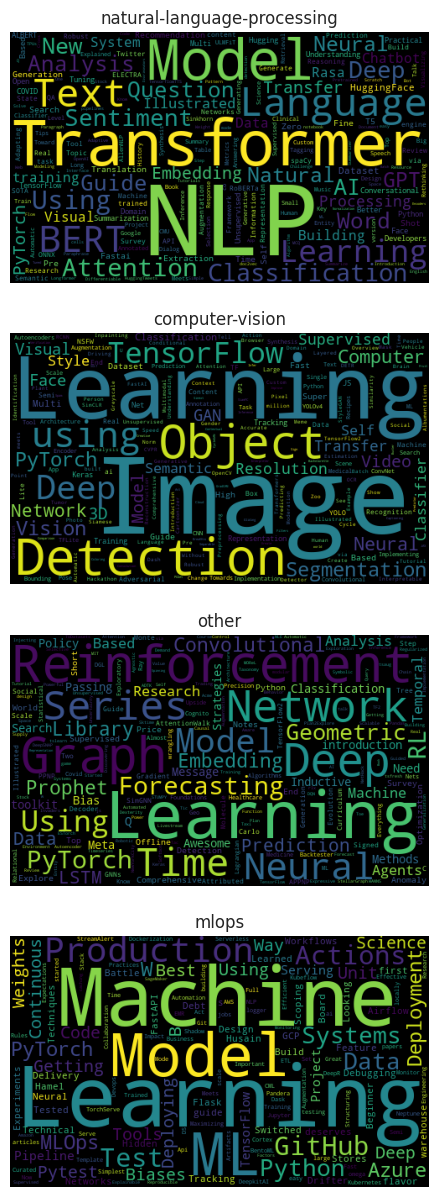

In [65]:
# Most frequent tokens for each tag in "title"

nbOfTags = len(tags)

fig, axs = plt.subplots(nbOfTags, figsize=(15, 15))

for tagNum, tag  in enumerate(tags) :
    #tag="natural-language-processing"
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    axs[tagNum].axis("off")
    axs[tagNum].imshow(cloud)
    axs[tagNum].set_title(tag)

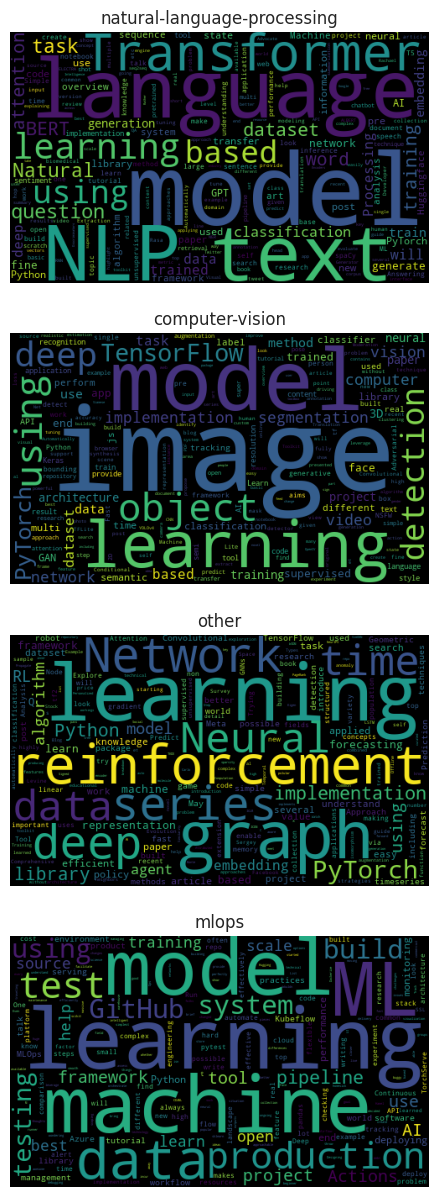

In [66]:
# Most frequent tokens for each tag in "description"

nbOfTags = len(tags)

fig, axs = plt.subplots(nbOfTags, figsize=(15, 15))

for tagNum, tag  in enumerate(tags) :
    #tag="natural-language-processing"
    subset = df[df.tag==tag]
    text = subset.description.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    axs[tagNum].axis("off")
    axs[tagNum].imshow(cloud)
    axs[tagNum].set_title(tag)

## 4 - Data Prerocessing

Data preprocessing can be categorized into two types of processes: preparation and transformation. We'll explore common preprocessing techniques and then we'll preprocess our dataset.



For our application, we'll be implementing a few of these preprocessing steps that are relevant for our dataset.

In [67]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

#### Feature engineering

We can combine existing input features to create new meaningful signal for helping the model learn. However, there's usually no simple way to know if certain feature combinations will help or not without empirically experimenting with the different combinations. Here, we could use a project's title and description separately as features but we'll combine them to create one input feature.

In [68]:
# Input
df["text"] = df.title + " " + df.description

#### Cleaning

Since we're dealing with text data, we can apply some common text preprocessing operations. Here, we'll be using Python's built-in regular expressions library re and the Natural Language Toolkit nltk.

In [69]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matfox44/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
def clean_text(text, stopwords=STOPWORDS) :
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [71]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [72]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


#### Encoding

We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [73]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [74]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [75]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [76]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

#### Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a tokenizer that was used for a pretrained LLM (scibert) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [77]:
import numpy as np
from transformers import BertTokenizer

In [78]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [79]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

#### Best practices

We'll wrap up by combining all of our preprocessing operations into function. This way we can easily apply it to different datasets (training, inference, etc.)

In [80]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [81]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)['targets'].shape

(611,)

## 5- Data Distribution

### Setup

The only setup we have to do is set Ray to preserve order when acting on our data. This is important for ensuring reproducible and deterministic results.

In [82]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

### Ingestion

We'll start by ingestiong our dataset. Ray has a range of input/output functions that support all major data formats and sources

In [83]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2023-11-22 12:34:33,164	INFO read_api.py:406 -- To satisfy the requested parallelism of 8, each read task output is split into 8 smaller blocks.
2023-11-22 12:34:33,174	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-22 12:34:33,174	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:34:33,175	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 1045,
  'created_on': datetime.datetime(2020, 5, 30, 1, 35, 24),
  'title': 'Illustrated Guide to Transformers: Step by Step Explanation',
  'description': 'In this post, we’ll focus on the one paper that started it all, “Attention is all you need”.',
  'tag': 'natural-language-processing'}]

### Splitting

Next, we'll split our dataset into our training and validation splits. Ray has a built-in « train_test_split » function but we're using a modified version so that we can stratify our split based on the « tag » column

In [84]:
from typing import Dict, List, Tuple
from ray.data import Dataset

def stratify_split(
    ds: Dataset,
    stratify: str,
    test_size: float,
    shuffle: bool = True,
    seed: int = 1234
    ) -> Tuple[Dataset, Dataset]:

    """
    Split a dataset into train and test splits with equal
    amounts of data points from each class in the column we
    want to stratify on.

    Args:
        ds (Dataset): Input dataset to split.
        stratify (str): Name of column to split on.
        test_size (float): Proportion of dataset to split for test set.
        shuffle (bool, optional): whether to shuffle the dataset. Defaults to True.
        seed (int, optional): seed for shuffling. Defaults to 1234.

    Returns:
        Tuple[Dataset, Dataset]: the stratified train and test datasets.

    """

    def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Naively split a dataframe into train and test splits.
        Add a column specifying whether it's the train or test split."""
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])

    def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        return df[df["_split"] == split].drop("_split", axis=1)

    # Train, test split with stratify
    grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
    train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
    test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

    # Shuffle each split (required)
    train_ds = train_ds.random_shuffle(seed=seed)
    test_ds = test_ds.random_shuffle(seed=seed)

    return train_ds, test_ds

In [85]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-11-22 12:34:33,852	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-22 12:34:33,853	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:34:33,853	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

### Preprocessing

And finally, we're ready to process our data splits. One of the advantages of using Ray is that we won't have to change anything to our original Pandas-based preprocessing function we implemented in the previous part. Instead, we can use directly with Ray's "map_batches" utility to map our preprocessing function across bacthes in ou data in a distributed manner.

In [86]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2023-11-22 12:34:34,215	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-22 12:34:34,216	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:34:34,216	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-22 12:34:34,847	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-22 12:34:34,848	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:34:34,849	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

In [87]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(
  preprocess,
  fn_kwargs={"class_to_index": class_to_index},
  batch_format="pandas")
sample_ds.show(1)

2023-11-22 12:34:35,360	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2023-11-22 12:34:35,361	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:34:35,362	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

{'ids': array([  102,  4928,  2095, 24921, 15689,  6392,  1085,  9559, 30113,
       22964,  2875,  4928,  2095,  2214, 20147, 13419, 24921, 15689,
        6392,  1085,  4928,  2095,  2641,  9559, 30113, 22964,   103,
           0,     0,     0,     0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 2}


# MODEL

## 1- SETUP

In [88]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

We'll define a simple load_data function to ingest our data from source (CSV files) and load it as a Ray Dataset.

In [237]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

We'll also define a custom preprocessor class that we'll to conveniently preprocess our dataset but also to save/load for later. When defining a preprocessor, we'll need to define a _fit method to learn how to fit to our dataset and a _transform_{pandas|numpy} method to preprocess the dataset using any components from the _fit method. We can either define a _transform_pandas method to apply our preprocessing to a Pandas DataFrame or a _transform_numpy method to apply our preprocessing to a NumPy array. We'll define the _transform_pandas method since our preprocessing function expects a batch of data as a Pandas DataFrame.

In [238]:
class CustomPreprocessor():
    """Custom preprocessor class."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        
    def fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    
    def transform(self, ds):
        return ds.map_batches(
            preprocess, 
            fn_kwargs={"class_to_index": self.class_to_index}, 
            batch_format="pandas")

## 2- Model

Now we're ready to start defining our model architecture. We'll start by loading a pretrained LLM and then defining the components needed for fine-tuning it on our dataset. Our pretrained LLM here is a transformer-based model that has been pretrained on a large corpus of scientific text called scibert.

In [91]:
import torch.nn as nn
from transformers import BertModel

We can load our pretrained model by using the from_pretrained` method.

In [92]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Once our model is loaded, we can tokenize an input text, convert it to torch tensors and pass it through our model to get a sequence and pooled representation of the text.

In [93]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

We're going to use this pretrained model to represent our input text features and add additional layers (linear classifier) on top of it for our specific classification task. In short, the pretrained LLM will process the tokenized text and return a sequence (one representation after each token) and pooled (combined) representation of the text. We'll use the pooled representation as input to our final fully-connection layer (fc1) to result in a vector of size num_classes (number of classes) that we can use to make predictions.

In [94]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z
    
    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred
    
    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z, dim=1).cpu().numpy()
        return y_probs
    
    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)
        torch.save(self.state_dict(), os.path.join(dp, "model.pt"))

    @classmethod
    def load(cls, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)
        llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(torch.load(state_dict_fp, map_location=torch.device("cpu")))
        return model

In [95]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## 3- Batching

We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (padding="longest"). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom collate_fn to repad the items in our training batches.

In [96]:
from ray.train.torch import get_device

Our pad_array function will take an array of arrays and pad the inner arrays to the longest length.

In [97]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

And our collate_fn will take a batch of data to pad them and convert them to the appropriate PyTorch tensor types.

In [98]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

Let's test our collate_fn on a sample batch from our dataset.

In [99]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2023-11-22 12:34:38,664	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2023-11-22 12:34:38,665	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:34:38,666	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

{'ids': tensor([[  102,   769, 30112,  ...,     0,     0,     0],
         [  102, 15156,  5702,  ...,     0,     0,     0],
         [  102,  1934, 22653,  ...,     0,     0,     0],
         ...,
         [  102,  7908,  1968,  ...,     0,     0,     0],
         [  102, 13288,  5923,  ...,     0,     0,     0],
         [  102,  3450, 15550,  ...,     0,     0,     0]], device='cuda:0',
        dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32),
 'targets': tensor([0, 1, 0, 3, 2, 2, 1, 2, 0, 2, 0, 3, 2, 2, 2, 1, 0, 1, 0, 0, 2, 3, 3, 0,
         2, 0, 2, 2, 2, 0, 0, 3, 2, 2, 0, 0, 0, 2, 0, 3, 0, 1, 3, 2, 2, 2, 0, 0,
         2, 0, 3, 0, 2, 0, 2, 2, 3, 2, 1, 0, 0, 0, 2, 2, 2, 3, 3, 2, 0, 0, 1, 2,
         0, 0, 2, 2, 2, 1, 0, 0, 3, 2, 2, 0, 2, 1, 2, 

## 4 - Utilities

Next, we'll implement set the necessary utility functions for distributed training.

In [100]:
from pathlib import Path
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

In [101]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

We'll start by defining what one step (or iteration) of training looks like. This will be a function that takes in a batch of data, a model, a loss function, and an optimizer. It will then perform a forward pass, compute the loss, and perform a backward pass to update the model's weights. And finally, it will return the loss.

In [102]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

Note: We're using the ray.data.iter_torch_batches method instead of torch.utils.data.DataLoader to create a generator that will yield batches of data. In fact, this is the only line that's different from a typical PyTorch training loop and the actual training workflow remains untouched.

The validation step is quite similar to the training step but we don't need to perform a backward pass or update the model's weights.

In [103]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

In [104]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train") # SPECIAL RAY!!! to load the data splits
    val_ds = train.get_dataset_shard("val") #SPECIAL RAY!!! to load the data splits 

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model) #SPECIAL RAY!!! to prepare the torch model for distributed execution
    
    # # Class weights
    # batch_counts = []
    # for batch in train_ds.iter_torch_batches(batch_size=256, collate_fn=collate_fn):
    #     batch_counts.append(np.bincount(batch["targets"].cpu().numpy()))
    # counts = [sum(count) for count in zip(*batch_counts)]
    # class_weights = np.array([1.0/count for i, count in enumerate(counts)])
    # class_weights_tensor = torch.Tensor(class_weights).to(get_device())

    # # Training components
    # loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)


    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    batch_size_per_worker = batch_size // train.get_context().get_world_size() # SPECIAL RAY!!!to adjust the batch size for each worker 
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory() as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint) # SPECIAL RAY!!! to report metrics and save our model checkpoint

## 5- Configurations

In [105]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

Next we'll define our scaling configuration (ScalingConfig) that will specify how we want to scale our training workload. We specify the number of workers (num_workers), whether to use GPU or not (use_gpu), the resources per worker (resources_per_worker) and how much CPU each worker is allowed to use (_max_cpu_fraction_per_node).

In [106]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker
)

Next, we'll define our CheckpointConfig which will specify how we want to checkpoint our model. Here we will just save one checkpoint (num_to_keep) based on the checkpoint with the min val_loss. We'll also configure a RunConfig which will specify the name of our run and where we want to save our checkpoints.

In [107]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, storage_path="~/ray_results")

We'll be naming our experiment llm and saving our results to ~/ray_results, so a sample directory structure for our trained models would look like this:

/home/ray/ray_results/llm

├── TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/

├── basic-variant-state-2023-07-20_18-14-50.json

├── experiment_state-2023-07-20_18-14-50.json

├── trainer.pkl

└── tuner.pkl

The TorchTrainer_ objects are the individuals runs in this experiment and each one will have the following contents:

/home/ray/ray_results/TorchTrainer_fd40a_00000_0_2023-07-20_18-14-50/

├── checkpoint_000009/  # we only save one checkpoint (the best)

├── events.out.tfevents.1689902160.ip-10-0-49-200

├── params.json

├── params.pkl

├── progress.csv

└── result.json

## 6- Training

Now we're finally ready to train our model using all the components we've setup above.

In [59]:
# Load and split data
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

# Preprocess
preprocessor = CustomPreprocessor()
preprocessor.fit(train_ds)
train_ds =  preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize() #it will cache the preprocessed data in memory
val_ds = val_ds.materialize()

2023-11-21 16:51:31,283	INFO read_api.py:406 -- To satisfy the requested parallelism of 8, each read task output is split into 8 smaller blocks.
2023-11-21 16:51:31,288	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-21 16:51:31,289	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:51:31,289	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-21 16:51:31,481	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-21 16:51:31,482	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:51:31,483	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-21 16:51:31,806	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-21 16:51:31,808	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:51:31,813	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-21 16:51:32,231	WARNING plan.py:567 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
2023-11-21 16:51:32,238	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-11-21 16:51:32,239	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:51:32,239

- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-21 16:51:32,912	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-11-21 16:51:32,912	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:51:32,913	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

Calling materialize here is important because it will cache the preprocessed data in memory. This will allow us to train our model without having to reprocess the data each time.

Because we've preprocessed the data prior to training, we can use the fit=False and transform=False flags in our dataset config. This will allow us to skip the preprocessing step during training.

In [60]:
# Dataset config
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(
    datasets_to_split=["train"],
    execution_options=options)

In [61]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [62]:
# Train
results = trainer.fit()

(TorchTrainer pid=1666) Starting distributed worker processes: ['1713 (172.24.97.175)']
(RayTrainWorker pid=1713) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=1765) Auto configuring locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b']
(RayTrainWorker pid=1713) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
(RayTrainWorker pid=1713) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertFor

(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000000)
(SplitCoordinator pid=1765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=1765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=1765) Tip: For detailed progress

(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000001)
(SplitCoordinator pid=1765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=1765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=1765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000002)
(SplitCoordinator pid=1765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=1765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=1765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000003)
2023-11-21 16:52:29,973	WARNING util.py:315 -- The `process_trial_save` operation took 2.383 s, which may be a performance bottleneck.
(SplitCoordinator pid=1765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=1765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=1765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000004)
(SplitCoordinator pid=1765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=1765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=1765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000005)
2023-11-21 16:52:55,281	WARNING util.py:315 -- The `process_trial_save` operation took 1.775 s, which may be a performance bottleneck.
(SplitCoordinator pid=1765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=1765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=1765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000006)
(SplitCoordinator pid=1765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=1765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=1765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000007)
(SplitCoordinator pid=1765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=1765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=1765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000008)
(SplitCoordinator pid=1765) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=1765) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=1765) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=1765) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=1713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000009)
2023-11-21 16:53:42,799	WARNING util.py:315 -- The `process_trial_save` operation took 1.409 s, which may be a performance bottleneck.
2023-11-21 16:53:44,363	INFO tune.py:1143 -- Total run time: 130.38 seconds (130.19 seconds for the tuning loop).


In [63]:
# Metrics per epoch
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.0001,0.578069,0.494483,1700581911,True,False,1,d8880_00000,2023-11-21_16-51-51,...,14.893646,1,checkpoint_000000,0.5,0.0001,0.8,3,10,256,4
1,1,0.0001,0.465783,0.414140,1700581922,True,False,2,d8880_00000,2023-11-21_16-52-02,...,25.978228,2,checkpoint_000001,0.5,0.0001,0.8,3,10,256,4
2,2,0.0001,0.343302,0.334014,1700581936,True,False,3,d8880_00000,2023-11-21_16-52-16,...,37.388599,3,checkpoint_000002,0.5,0.0001,0.8,3,10,256,4
3,3,0.0001,0.253906,0.285744,1700581947,True,False,4,d8880_00000,2023-11-21_16-52-27,...,48.439594,4,checkpoint_000003,0.5,0.0001,0.8,3,10,256,4
4,4,0.0001,0.183811,0.258009,1700581961,True,False,5,d8880_00000,2023-11-21_16-52-41,...,59.637817,5,checkpoint_000004,0.5,0.0001,0.8,3,10,256,4
5,5,0.0001,0.146487,0.234145,1700581972,True,False,6,d8880_00000,2023-11-21_16-52-52,...,71.365286,6,checkpoint_000005,0.5,0.0001,0.8,3,10,256,4
6,6,0.0001,0.091661,0.227945,1700581986,True,False,7,d8880_00000,2023-11-21_16-53-06,...,82.722940,7,checkpoint_000006,0.5,0.0001,0.8,3,10,256,4
7,7,0.0001,0.066129,0.232664,1700581997,True,False,8,d8880_00000,2023-11-21_16-53-17,...,93.654171,8,checkpoint_000007,0.5,0.0001,0.8,3,10,256,4
8,8,0.0001,0.044883,0.244910,1700582010,True,False,9,d8880_00000,2023-11-21_16-53-30,...,106.366292,9,checkpoint_000008,0.5,0.0001,0.8,3,10,256,4
9,9,0.0001,0.033048,0.279647,1700582021,True,False,10,d8880_00000,2023-11-21_16-53-41,...,117.397116,10,checkpoint_000009,0.5,0.0001,0.8,3,10,256,4


In [64]:
# Best checkpoints
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/home/matfox44/ray_results/llm/TorchTrainer_d8880_00000_0_2023-11-21_16-51-34/checkpoint_000006),
  {'epoch': 6,
   'lr': 0.0001,
   'train_loss': 0.0916610558827718,
   'val_loss': 0.22794507443904877,
   'timestamp': 1700581986,
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 7,
   'trial_id': 'd8880_00000',
   'date': '2023-11-21_16-53-06',
   'time_this_iter_s': 11.357653617858887,
   'time_total_s': 82.72293972969055,
   'pid': 1666,
   'hostname': 'DESKTOP-KUC4OSD',
   'node_ip': '172.24.97.175',
   'config': {'train_loop_config': {'dropout_p': 0.5,
     'lr': 0.0001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 10,
     'batch_size': 256,
     'num_classes': 4}},
   'time_since_restore': 82.72293972969055,
   'iterations_since_restore': 7})]

## 7- Evaluation

Now that we've trained our model, we can evaluate it on a separate holdout test set. We'll cover the topic of evaluation much more extensively in our evaluation lesson but for now we'll calculate some quick overall metrics.

In [239]:
from sklearn.metrics import precision_recall_fscore_support

In [240]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()
        
    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}
        
    def get_preprocessor(self):
        return self.preprocessor
        
    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

1- Load the predictor and preprocessor from the best checkpoint:

In [67]:
# Artifacts
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2- Load and preprocess the test dataset that we want to evaluate on:

In [68]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

2023-11-21 16:53:46,037	INFO read_api.py:406 -- To satisfy the requested parallelism of 8, each read task output is split into 8 smaller blocks.
2023-11-21 16:53:46,040	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2023-11-21 16:53:46,041	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:53:46,041	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'ids': array([  102,  4905,  2069,  2470,  2848,  4905, 30132, 22081,   691,
          4324,  7491,  5896,   341,  6136,   934, 30137,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'targets': 3}]

In [69]:
# y_pred
predictions = preprocessed_ds.map_batches(predictor).take_all()
y_pred = np.array([d["output"] for d in predictions])

2023-11-21 16:53:47,009	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-11-21 16:53:47,011	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:53:47,011	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=1170) /tmp/ipykernel_923/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


In [70]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

2023-11-21 16:53:53,709	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-11-21 16:53:53,710	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:53:53,710	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

[3 3 3 0 2 0 0 0 0 2 0 0 2 3 0 0 2 2 3 2 3 0 3 2 0 2 2 1 1 2 2 2 2 2 2 0 0
 0 0 0 1 1 2 0 0 3 1 2 0 2 2 3 3 0 2 3 2 3 3 3 3 0 0 0 0 2 2 0 2 1 0 2 3 0
 0 2 2 2 2 2 0 0 2 0 1 0 0 0 0 3 0 0 2 0 2 2 3 2 0 2 0 2 0 3 0 0 0 0 0 2 0
 0 2 2 2 2 3 0 2 0 2 0 2 3 3 3 2 0 2 2 2 2 0 2 2 2 0 1 2 2 2 2 2 1 2 0 3 0
 2 2 1 1 2 0 0 0 0 0 0 2 2 2 0 2 1 1 2 0 0 1 2 3 2 2 2 0 0 2 0 2 0 3 0 2 2
 0 1 2 1 2 2]


In [71]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.932955206515416,
 'recall': 0.9319371727748691,
 'f1': 0.9315546022464285}

We're going to encapsulate all of these steps into one function so that we can call on it as we train more models soon.

In [128]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])
    
    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [73]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2023-11-21 16:53:54,488	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-11-21 16:53:54,489	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:53:54,489	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

2023-11-21 16:53:55,404	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-11-21 16:53:55,404	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:53:55,405	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

{
  "precision": 0.932955206515416,
  "recall": 0.9319371727748691,
  "f1": 0.9315546022464285
}


## 8- Inference

Now let's load our trained model for inference on new data. We'll create a few utility functions to format the probabilities into a dictionary for each class and to return predictions for each item in a dataframe.

In [133]:
import pandas as pd

Define a function that take as input the probability of each index and attribute it to the class

In [132]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

Define a function that take as input the a Dataset and the TorchPredictor tthen return the estimated class and the prob of each one

In [241]:
def predict_proba(ds, predictor):
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    results = []
    for i, prob in enumerate(y_prob):
        tag = preprocessor.index_to_class[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [80]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2023-11-21 16:58:43,230	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-11-21 16:58:43,231	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 16:58:43,232	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{0: 'computer-vision', 1: 'mlops', 2: 'natural-language-processing', 3: 'other'}


[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.0010659118,
   'mlops': 0.00098317,
   'natural-language-processing': 0.9968263,
   'other': 0.001124606}}]

# EXPERIMENT TRACKING

So far, we've been training our models but we don't have a way to more deeply track and compare them. We'll achieve this but defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). Experiment tracking is the processing of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

- **Organize** all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
- **Reproduce** past results (easily) using saved experiments.
- **Log** iterative improvements across time, data, ideas, teams, etc.

There are many options for experiment tracking but we're going to use [MLflow](https://mlflow.org/) (100% free and [open-source](https://github.com/mlflow/mlflow)) because it has all the functionality we'll need (and [growing integration support](https://docs.ray.io/en/latest/tune/examples/tune-mlflow.html)). There are also several popular options such as a [Comet ML](https://www.comet.ml/site/) (Used by Google AI, HuggingFace, etc.) and [Weights and Biases](https://www.wandb.com/) (Used by Open AI, Toyota Research, etc.). These are fantastic options if you want a fully managed experiment tracking solution.

In [242]:
import mlflow
from pathlib import Path
from ray.tune.logger.mlflow import MLflowLoggerCallback
import time

## 1- SETUP

In [243]:
EFS_DIR = "/tmp"

# Config MLflow
MODEL_REGISTRY = Path(f"{EFS_DIR}/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

file:///tmp/mlflow


## 2- Running an experiment

While we could use MLflow directly to log metrics, artifacts and parameters:

In [84]:
# # Example mlflow calls
# mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)
# mlflow.log_artifacts(dir)
# mlflow.log_params(config)


We'll instead use Ray to integrate with MLflow. Specifically we'll use the MLflowLoggerCallback which will automatically log all the necessary components of our experiments to the location specified in our MLFLOW_TRACKING_URI. We of course can still use MLflow directly if we want to log something that's not automatically logged by the callback. And if we're using other experiment trackers, Ray has integrations for those as well.

In [85]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [86]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR
)

In [87]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-11-21 17:10:41,404	INFO read_api.py:406 -- To satisfy the requested parallelism of 8, each read task output is split into 8 smaller blocks.
2023-11-21 17:10:41,408	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-21 17:10:41,409	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:10:41,409	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [88]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-11-21 17:10:48,520	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-21 17:10:48,521	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:10:48,522	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-21 17:10:49,088	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-21 17:10:49,090	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:10:49,095	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-21 17:10:49,593	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-11-21 17:10:49,594	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:10:49,596	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-21 17:10:50,601	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-11-21 17:10:50,602	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:10:50,603	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

In [89]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [90]:
%%time
# Train
results = trainer.fit()

(TorchTrainer pid=5659) Starting distributed worker processes: ['5706 (172.24.97.175)']
(RayTrainWorker pid=5706) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=5758) Auto configuring locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b']
(RayTrainWorker pid=5706) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(RayTrainWorker pid=5706) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertFor

(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) /tmp/ipykernel_923/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
(RayTrainWorker pid=5706) Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11

(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11-16/checkpoint_000001)
2023-11-21 17:11:35,537	WARNING util.py:315 -- The `process_trial_save` operation took 0.802 s, which may be a performance bottleneck.
(SplitCoordinator pid=5758) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5758) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5758) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11-16/checkpoint_000002)
2023-11-21 17:11:45,743	WARNING util.py:315 -- The `process_trial_save` operation took 3.563 s, which may be a performance bottleneck.
(SplitCoordinator pid=5758) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5758) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5758) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11-16/checkpoint_000003)
(SplitCoordinator pid=5758) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5758) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5758) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11-16/checkpoint_000004)
(SplitCoordinator pid=5758) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5758) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5758) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11-16/checkpoint_000005)
(SplitCoordinator pid=5758) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5758) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5758) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11-16/checkpoint_000006)
(SplitCoordinator pid=5758) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5758) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5758) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11-16/checkpoint_000007)
(SplitCoordinator pid=5758) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5758) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5758) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11-16/checkpoint_000008)
2023-11-21 17:12:26,498	WARNING util.py:315 -- The `process_trial_save` operation took 0.649 s, which may be a performance bottleneck.
(SplitCoordinator pid=5758) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=5758) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=5758) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=5758) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(RayTrainWorker pid=5706) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-11-16/TorchTrainer_9991e_00000_0_2023-11-21_17-11-16/checkpoint_000009)
2023-11-21 17:12:36,119	INFO tune.py:1143 -- Total run time: 79.28 seconds (79.23 seconds for the tuning loop).


CPU times: user 1.13 s, sys: 935 ms, total: 2.07 s
Wall time: 1min 19s


In [91]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.config/train_loop_config/dropout_p,metrics.epoch,metrics.config/train_loop_config/num_classes,metrics.should_checkpoint,...,metrics.time_total_s,params.train_loop_config/lr,params.train_loop_config/batch_size,params.train_loop_config/lr_factor,params.train_loop_config/num_classes,params.train_loop_config/dropout_p,params.train_loop_config/num_epochs,params.train_loop_config/lr_patience,tags.mlflow.runName,tags.trial_name
0,c6bd16d05fb24740be85c83d0f3278d4,428626444489599897,FINISHED,file:///tmp/mlflow/428626444489599897/c6bd16d0...,2023-11-21 16:11:19.483000+00:00,2023-11-21 16:12:36.091000+00:00,0.5,9.0,4.0,1.0,...,67.95639,0.0001,256,0.8,4,0.5,10,3,TorchTrainer_9991e_00000,TorchTrainer_9991e_00000


In [92]:
# Best run
best_run = sorted_runs.iloc[0]
best_run

run_id                                                           c6bd16d05fb24740be85c83d0f3278d4
experiment_id                                                                  428626444489599897
status                                                                                   FINISHED
artifact_uri                                    file:///tmp/mlflow/428626444489599897/c6bd16d0...
start_time                                                       2023-11-21 16:11:19.483000+00:00
end_time                                                         2023-11-21 16:12:36.091000+00:00
metrics.config/train_loop_config/dropout_p                                                    0.5
metrics.epoch                                                                                 9.0
metrics.config/train_loop_config/num_classes                                                  4.0
metrics.should_checkpoint                                                                     1.0
metrics.timestamp   

## 3- Dashboard

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port:

```bash
mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri $EFS_DIR/mlflow
```
Link local :
http://localhost:8080/

## 4- Loading

After inspection and once we've identified an experiment that we like, we can load the model for evaluation and inference.

In [110]:
from ray.train import Result
from urllib.parse import urlparse

We're going to create a small utility function that uses an MLflow run's artifact path to load a Ray Result object. We'll then use the Result object to load the best checkpoint.

In [244]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

In [245]:
def get_last_exp_name() :
    # Find all experimennts
    all_experiments = mlflow.search_experiments()

    # Get lastest experiement 
    return all_experiments[-1].name

In [246]:

def extract_best_run(experiment_name) :
    # Sorted runs
    sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
    sorted_runs
    # Best run
    return sorted_runs.iloc[0]

In [247]:
experiment_name = get_last_exp_name()
best_run = extract_best_run(experiment_name)

In [248]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [129]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2023-11-22 12:45:08,196	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-11-22 12:45:08,196	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:45:08,197	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

2023-11-22 12:45:09,272	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-11-22 12:45:09,274	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:45:09,274	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor) pid=26052) /tmp/ipykernel_24822/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


{
  "precision": 0.9221179677858288,
  "recall": 0.9214659685863874,
  "f1": 0.9197929862044795
}


In [134]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2023-11-22 12:45:58,221	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-11-22 12:45:58,222	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:45:58,222	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.0025161507,
   'mlops': 0.0020180207,
   'natural-language-processing': 0.9942567,
   'other': 0.0012091323}}]

# HYPERPARAMETER TUNING

There are many options for hyperparameter tuning (Ray tune, Optuna, Hyperopt, etc.). We'll be using Ray Tune with it's HyperOpt integration for it's simplicity and general popularity. Ray Tune also has a wide variety of support for many other tune search algorithms (Optuna, Bayesian, etc.)

## 1- SETUP 

In [102]:
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch

In [103]:
# Number of trials (small sample)
num_runs = 2

In [104]:
# Set up
set_seeds()

In [105]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-11-21 17:37:05,430	INFO read_api.py:406 -- To satisfy the requested parallelism of 8, each read task output is split into 8 smaller blocks.
2023-11-21 17:37:05,435	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-11-21 17:37:05,436	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:37:05,437	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [106]:
# Preprocess
preprocessor = CustomPreprocessor()
preprocessor = preprocessor.fit(train_ds)
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-11-21 17:37:11,022	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-11-21 17:37:11,023	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:37:11,023	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-21 17:37:11,742	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-11-21 17:37:11,744	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:37:11,749	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-21 17:37:12,190	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-11-21 17:37:12,191	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:37:12,198	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

2023-11-21 17:37:13,167	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-11-21 17:37:13,168	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-21 17:37:13,169	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/64 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/64 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/64 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/64 [00:00<?, ?it/s]

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/8 [00:00<?, ?it/s]

In [107]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata={"class_to_index": preprocessor.class_to_index}
)

In [110]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

## 2- Tune Config

We can think of tuning as training across different combinations of parameters. For this, we'll need to define several configurations around when to stop tuning (stopping criteria), how to define the next set of parameters to train with (search algorithm) and even the different values that the parameters can take (search space).

We'll start by defining our CheckpointConfig and RunConfig as we did for training:

In [111]:
# Run configuration
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
    storage_path=EFS_DIR,
    local_dir=EFS_DIR)

### 2.1 Search algorithm

Next, we're going to set the initial parameter values and the search algorithm (HyperOptSearch) for our tuning experiment. We're also going to set the maximum number of trials that can be run concurrently (ConcurrencyLimiter) based on the compute resources we have.

In [112]:
# Hyperparameters to start with
initial_params = [{"train_loop_config": {"dropout_p": 0.5, "lr": 1e-4, "lr_factor": 0.8, "lr_patience": 3}}]
search_alg = HyperOptSearch(points_to_evaluate=initial_params)
search_alg = ConcurrencyLimiter(search_alg, max_concurrent=2)  # trade off b/w optimization and search space

### 2.2  Search space

Next, we're going to define the parameter search space by choosing the parameters, their distribution and range of values. Depending on the parameter type, we have many different distributions to choose from.

In [113]:
# Parameter space
param_space = {
    "train_loop_config": {
        "dropout_p": tune.uniform(0.3, 0.9),
        "lr": tune.loguniform(1e-5, 5e-4),
        "lr_factor": tune.uniform(0.1, 0.9),
        "lr_patience": tune.uniform(1, 10),
    }
}

### 2.3 Scheduler 

Next, we're going to define a scheduler to prune unpromising trials. We'll be using AsyncHyperBandScheduler (ASHA), which is a very popular and aggressive early-stopping algorithm. Due to our aggressive scheduler, we'll set a grace_period to allow the trials to run for at least a few epochs before pruning and a maximum of max_t epochs

In [114]:
# Scheduler
scheduler = AsyncHyperBandScheduler(
    max_t=train_loop_config["num_epochs"],  # max epoch (<time_attr>) per trial
    grace_period=5,  # min epoch (<time_attr>) per trial
)

### 2.4 Tune Config

Finally, we're going to define a TuneConfig that will combine the search_alg and scheduler we've defined above.

In [115]:
# Tune config
tune_config = tune.TuneConfig(
    metric="val_loss",
    mode="min",
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=num_runs,
)

## 3- Tuner

And now, we'll pass in our trainer object with our configurations to create a Tuner object that we can run.

In [116]:
# Tuner
tuner = Tuner(
    trainable=trainer,
    run_config=run_config,
    param_space=param_space,
    tune_config=tune_config,
)

In [117]:
# Tune
results = tuner.fit()

(TorchTrainer pid=13290) Starting distributed worker processes: ['13344 (172.24.97.175)']
(RayTrainWorker pid=13344) Setting up process group for: env:// [rank=0, world_size=1]
(SplitCoordinator pid=13396) Auto configuring locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b']
(RayTrainWorker pid=13344) Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
(RayTrainWorker pid=13344) - This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a B

(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) /tmp/ipykernel_923/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../tor

(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_b14399e9_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-21_17-49-48/checkpoint_000001)


(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_b14399e9_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-21_17-49-48/checkpoint_000002)


(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_b14399e9_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-21_17-49-48/checkpoint_000003)


(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_b14399e9_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-21_17-49-48/checkpoint_000004)


(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_b14399e9_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-21_17-49-48/checkpoint_000005)


(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_b14399e9_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-21_17-49-48/checkpoint_000006)


(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_b14399e9_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-21_17-49-48/checkpoint_000007)


(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_b14399e9_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-21_17-49-48/checkpoint_000008)


(pid=13396) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=13396) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=13396) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=13396) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=13344) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_b14399e9_1_dropout_p=0.5000,lr=0.0001,lr_factor=0.8000,lr_patience=3.0000_2023-11-21_17-49-48/checkpoint_000009)
(TorchTrainer pid=14117) Starting distributed worker processes: ['14168 (172.24.97.175)']
(RayTrainWorker pid=14168) Setting up process group for: env:// [rank=0, world_size=1]
(Sp

(pid=14220) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=14220) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=14220) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=14220) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=14168) Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(RayTrainWorker pid=14168) Checkpoint successfully created at: Checkpoint(filesystem=local, pa

(pid=14220) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=14220) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=14220) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=14220) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=14168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_81de1eb7_2_dropout_p=0.5550,lr=0.0000,lr_factor=0.8908,lr_patience=4.6416_2023-11-21_17-49-50/checkpoint_000001)


(pid=14220) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=14220) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=14220) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=14220) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=14168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_81de1eb7_2_dropout_p=0.5550,lr=0.0000,lr_factor=0.8908,lr_patience=4.6416_2023-11-21_17-49-50/checkpoint_000002)


(pid=14220) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=14220) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=14220) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=14220) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=14168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_81de1eb7_2_dropout_p=0.5550,lr=0.0000,lr_factor=0.8908,lr_patience=4.6416_2023-11-21_17-49-50/checkpoint_000003)


(pid=14220) Running 0:   0%|          | 0/8 [00:00<?, ?it/s]

(SplitCoordinator pid=14220) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=14220) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=['69861b7acf67fcbc27ade2fd34ecd0054dba1f3afee0774cf559436b'], preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=14220) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=14168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/TorchTrainer_2023-11-21_17-49-41/TorchTrainer_81de1eb7_2_dropout_p=0.5550,lr=0.0000,lr_factor=0.8908,lr_patience=4.6416_2023-11-21_17-49-50/checkpoint_000004)
2023-11-21 17:55:49,410	INFO tune.py:1143 -- Total run time: 361.39 seconds (361.35 seconds for the tuning loop).


In [118]:
# All trials in experiment
results.get_dataframe()

,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,logdir
0,9,0.000100,0.051971,0.220477,1700585558,True,True,10,b14399e9,2023-11-21_17-52-38,...,DESKTOP-KUC4OSD,172.24.97.175,163.779190,10,checkpoint_000009,0.500000,0.000100,0.800000,3.000000,b14399e9
1,4,0.000038,0.353688,0.361539,1700585741,True,True,5,81de1eb7,2023-11-21_17-55-41,...,DESKTOP-KUC4OSD,172.24.97.175,111.847714,5,checkpoint_000004,0.555022,0.000038,0.890767,4.641639,81de1eb7


In [123]:
# Best trial's epochs
best_trial = results.get_best_result(metric="val_loss", mode="min")
best_trial.metrics_dataframe


,epoch,lr,train_loss,val_loss,timestamp,should_checkpoint,done,training_iteration,trial_id,date,...,pid,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience
0,0,0.0001,0.580329,0.498303,1700585405,True,False,1,b14399e9,2023-11-21_17-50-05,...,13290,DESKTOP-KUC4OSD,172.24.97.175,14.555021,1,checkpoint_000000,0.5,0.0001,0.8,3.0
1,1,0.0001,0.475492,0.433485,1700585422,True,False,2,b14399e9,2023-11-21_17-50-22,...,13290,DESKTOP-KUC4OSD,172.24.97.175,31.413292,2,checkpoint_000001,0.5,0.0001,0.8,3.0
2,2,0.0001,0.394246,0.405856,1700585438,True,False,3,b14399e9,2023-11-21_17-50-38,...,13290,DESKTOP-KUC4OSD,172.24.97.175,47.526504,3,checkpoint_000002,0.5,0.0001,0.8,3.0
3,3,0.0001,0.316415,0.354785,1700585455,True,False,4,b14399e9,2023-11-21_17-50-55,...,13290,DESKTOP-KUC4OSD,172.24.97.175,64.508848,4,checkpoint_000003,0.5,0.0001,0.8,3.0
4,4,0.0001,0.248914,0.290966,1700585472,True,False,5,b14399e9,2023-11-21_17-51-12,...,13290,DESKTOP-KUC4OSD,172.24.97.175,79.939989,5,checkpoint_000004,0.5,0.0001,0.8,3.0
5,5,0.0001,0.187335,0.238520,1700585489,True,False,6,b14399e9,2023-11-21_17-51-29,...,13290,DESKTOP-KUC4OSD,172.24.97.175,95.476210,6,checkpoint_000005,0.5,0.0001,0.8,3.0
6,6,0.0001,0.139287,0.217234,1700585506,True,False,7,b14399e9,2023-11-21_17-51-46,...,13290,DESKTOP-KUC4OSD,172.24.97.175,112.653298,7,checkpoint_000006,0.5,0.0001,0.8,3.0
7,7,0.0001,0.092619,0.211351,1700585524,True,False,8,b14399e9,2023-11-21_17-52-04,...,13290,DESKTOP-KUC4OSD,172.24.97.175,129.907035,8,checkpoint_000007,0.5,0.0001,0.8,3.0
8,8,0.0001,0.072389,0.215312,1700585541,True,False,9,b14399e9,2023-11-21_17-52-21,...,13290,DESKTOP-KUC4OSD,172.24.97.175,146.747756,9,checkpoint_000008,0.5,0.0001,0.8,3.0
9,9,0.0001,0.051971,0.220477,1700585558,True,True,10,b14399e9,2023-11-21_17-52-38,...,13290,DESKTOP-KUC4OSD,172.24.97.175,163.779190,10,checkpoint_000009,0.5,0.0001,0.8,3.0


In [122]:
# Best trial's hyperparameters
best_trial.config["train_loop_config"]

{'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3.0}

In [121]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.config/train_loop_config/dropout_p,metrics.epoch,metrics.time_total_s,metrics.timestamp,...,metrics.iterations_since_restore,metrics.config/train_loop_config/lr,metrics.config/train_loop_config/lr_factor,metrics.should_checkpoint,params.train_loop_config/lr_factor,params.train_loop_config/dropout_p,params.train_loop_config/lr,params.train_loop_config/lr_patience,tags.mlflow.runName,tags.trial_name
0,1810ab9d8e2e4cf3b40f964c590501f4,536660412288134888,FINISHED,file:///tmp/mlflow/536660412288134888/1810ab9d...,2023-11-21 16:49:50.820000+00:00,2023-11-21 16:53:04.108000+00:00,0.500000,9.0,163.779190,1.700586e+09,...,10.0,0.000100,0.800000,1.0,0.8,0.5,0.0001,3.0,TorchTrainer_b14399e9,TorchTrainer_b14399e9
1,006ed63349e94b1db4aeb17c593a7988,536660412288134888,FINISHED,file:///tmp/mlflow/536660412288134888/006ed633...,2023-11-21 16:53:08.173000+00:00,2023-11-21 16:55:49.377000+00:00,0.555022,4.0,111.847714,1.700586e+09,...,5.0,0.000038,0.890767,1.0,0.8907669515858627,0.5550216954499337,3.821496576540376e-05,4.6416389178225845,TorchTrainer_81de1eb7,TorchTrainer_81de1eb7


## 4- Evaluation

In [133]:
# Artifacts
best_checkpoint = get_best_checkpoint(run_id=best_run.run_id)
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [135]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

2023-11-22 12:49:27,886	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-11-22 12:49:27,887	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:49:27,888	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

2023-11-22 12:49:29,007	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-11-22 12:49:29,007	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:49:29,008	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

{
  "precision": 0.9221179677858288,
  "recall": 0.9214659685863874,
  "f1": 0.9197929862044795
}


In [136]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_ds = ray.data.from_items([{"title": title, "description": description, "tag": "other"}])
predict_proba(ds=sample_ds, predictor=predictor)

2023-11-22 12:52:06,329	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-11-22 12:52:06,330	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 12:52:06,330	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'prediction': 'natural-language-processing',
  'probabilities': {'computer-vision': 0.0025161507,
   'mlops': 0.0020180207,
   'natural-language-processing': 0.9942567,
   'other': 0.0012091323}}]

# EVALUATION

## 0- Initialization
So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

- Coarse-grained metrics
- Fine-grained metrics
- Confusion matrix
- Confidence learning
- Slice metrics

In [137]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [138]:
# Artifacts
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [139]:
# y_test
preprocessed_ds = preprocessor.transform(test_ds)
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_test = np.stack([item["targets"] for item in values])

2023-11-22 13:00:05,129	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(<lambda>)]
2023-11-22 13:00:05,130	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 13:00:05,131	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

In [140]:
# y_prob
outputs = preprocessed_ds.map_batches(predictor.predict_proba)
y_prob = np.array([d["output"] for d in outputs.take_all()])

2023-11-22 13:00:17,864	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-11-22 13:00:17,865	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 13:00:17,866	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

In [141]:
# y_prob
print (np.shape(y_test))
print (np.shape(y_prob))

(191,)
(191, 4)


In [150]:
y_pred=y_prob.argmax(1)
y_pred

array([0, 3, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 2, 2, 3, 2, 3, 0,
       0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 3, 1, 2, 0, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 2,
       2, 0, 2, 1, 0, 2, 3, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 0, 0,
       0, 3, 0, 0, 2, 0, 2, 2, 3, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 1, 2, 2, 2, 3, 0, 2, 0, 2, 0, 2, 3, 3, 3, 2, 0, 2, 2, 0, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 3, 0, 2, 2, 1, 1, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 1, 2, 3, 2, 2, 2, 0,
       0, 2, 0, 2, 0, 3, 0, 2, 2, 0, 1, 2, 2, 2, 2])

In [151]:
# Add columns (for convenience)
test_df = pd.read_csv(HOLDOUT_LOC)
y_pred
test_df["text"] = test_df["title"] + " " + test_df["description"]
test_df["prediction"] = test_df.index.map(lambda i: preprocessor.index_to_class[y_pred[i]])
test_df.head()

,id,created_on,title,description,tag,text,prediction
0,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other,Diffusion to Vector Reference implementation o...,computer-vision
1,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other,Graph Wavelet Neural Network A PyTorch impleme...,other
2,44,2020-03-08 00:32:58,Capsule Graph Neural Network,"A PyTorch implementation of ""Capsule Graph Neu...",other,Capsule Graph Neural Network A PyTorch impleme...,other
3,80,2020-03-20 05:59:32,NeRF: Neural Radiance Fields,Representing scenes as neural radiance fields ...,computer-vision,NeRF: Neural Radiance Fields Representing scen...,computer-vision
4,84,2020-03-20 15:18:43,Mention Classifier,Category prediction model\nThis repo contains ...,natural-language-processing,Mention Classifier Category prediction model\n...,natural-language-processing


## 1- Coarse-grained metrics

In [152]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9221179677858288,
    "recall": 0.9214659685863874,
    "f1": 0.9197929862044795,
    "num_samples": 191.0
}


## 2- Fine-grained metrics

In [153]:
from collections import OrderedDict

In [154]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(preprocessor.class_to_index):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [158]:
metrics["class"][tag]

{'precision': 0.9156626506024096,
 'recall': 0.9743589743589743,
 'f1': 0.9440993788819876,
 'num_samples': 78.0}

In [155]:
# Metrics for a specific class 'NLP'
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.9156626506024096,
  "recall": 0.9743589743589743,
  "f1": 0.9440993788819876,
  "num_samples": 78.0
}


In [156]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "natural-language-processing",
  {
    "precision": 0.9156626506024096,
    "recall": 0.9743589743589743,
    "f1": 0.9440993788819876,
    "num_samples": 78.0
  }
]
[
  "computer-vision",
  {
    "precision": 0.9178082191780822,
    "recall": 0.9436619718309859,
    "f1": 0.9305555555555556,
    "num_samples": 71.0
  }
]
[
  "other",
  {
    "precision": 1.0,
    "recall": 0.8461538461538461,
    "f1": 0.9166666666666666,
    "num_samples": 26.0
  }
]
[
  "mlops",
  {
    "precision": 0.8461538461538461,
    "recall": 0.6875,
    "f1": 0.7586206896551724,
    "num_samples": 16.0
  }
]


## 3- Confusion Matrix

- **True positives (TP)**: learn about where our model performs well.
- **False positives (FP)**: potentially identify samples which may need to be relabeled.
- False negatives (FN): identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [176]:
# TP, FP, FN samples
tag = "natural-language-processing"
index = preprocessor.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [177]:
print (tp)
print (fp)
print (fn)

[4, 9, 12, 16, 17, 19, 23, 25, 26, 29, 30, 31, 32, 33, 34, 42, 47, 49, 50, 54, 56, 65, 66, 68, 71, 75, 76, 77, 78, 79, 82, 92, 94, 95, 97, 99, 101, 109, 113, 114, 115, 118, 120, 122, 126, 128, 129, 131, 133, 134, 135, 138, 139, 140, 141, 142, 144, 148, 149, 152, 159, 160, 161, 163, 166, 170, 172, 173, 174, 177, 179, 183, 184, 187, 189, 190]
[24, 44, 55, 104, 164, 165, 188]
[112, 130]


In [178]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"{test_df.iloc[index].text}")
            print (f"{test_df.iloc[index].text}")
            print (f"    true: {test_df.tag[index]}")
            print (f"    pred: {test_df.prediction[index]}\n")


=== True positives ===
Mention Classifier Category prediction model
This repo contains AllenNLP model for prediction of Named Entity categories by its mentions.
    true: natural-language-processing
    pred: natural-language-processing

Finetune: Scikit-learn Style Model Finetuning for NLP Finetune is a library that allows users to leverage state-of-the-art pretrained NLP models for a wide variety of downstream tasks.
    true: natural-language-processing
    pred: natural-language-processing

Finetuning Transformers with JAX + Haiku Walking through a port of the RoBERTa pre-trained model to JAX + Haiku, then fine-tuning the model to solve a downstream task.
    true: natural-language-processing
    pred: natural-language-processing


=== False positives ===
Keras OCR A packaged and flexible version of the CRAFT text detector and Keras CRNN recognition model. 
    true: computer-vision
    pred: natural-language-processing

Transfer Learning & Fine-Tuning With Keras Your 100% up-to-d

## 4- Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

**Categorical**
- prediction is incorrect (also indicate TN, FP, FN)
- confidence score for the correct class is below a threshold
- confidence score for an incorrect class is above a threshold
- standard deviation of confidence scores over top N samples is low
- different predictions from same model using different parameters

**Continuous**
- difference between predicted and ground-truth values is above some %



> The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

In [180]:
# Tag to inspect
tag = "natural-language-processing"
index = class_to_index[tag]
indices = np.where(y_test==index)[0]

In [181]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({
            "text": f"{test_df.iloc[i].text}",
            "true": test_df.tag[i], 
            "pred": test_df.prediction[i], 
            "prob": prob})

In [183]:
low_confidence[0:3]

[{'text': 'The Unreasonable Effectiveness of Recurrent Neural Networks A close look at how RNNs are able to perform so well.',
  'true': 'natural-language-processing',
  'pred': 'natural-language-processing',
  'prob': 0.3610482},
 {'text': 'Machine Learning Projects  This Repo contains projects done by me while learning the basics. All the familiar types of regression, classification, and clustering methods have been used.',
  'true': 'natural-language-processing',
  'pred': 'mlops',
  'prob': 0.020530026},
 {'text': "How to Benchmark Models with Transformers HuggingFace's Transformer library allows users to benchmark models for both TensorFlow 2 and PyTorch using the PyTorchBenchmark and TensorFlowBenchmark classes.",
  'true': 'natural-language-processing',
  'pred': 'computer-vision',
  'prob': 0.0068538655}]

But these are fairly crude techniques because neural networks are easily [overconfident](https://arxiv.org/abs/1706.04599) and so their confidences cannot be used without calibrating them. 

<div class="ai-center-all">
    <img src="https://madewithml.com/static/images/mlops/evaluation/calibration.png" width="300" alt="accuracy vs. confidence">
</div>
<div class="ai-center-all mt-1">
  <small>Modern (large) neural networks result in higher accuracies but are over confident.<br><a href="https://arxiv.org/abs/1706.04599" target="_blank">On Calibration of Modern Neural Networks</a></small>
</div>

* **Assumption**: *“the probability associated with the predicted class label should reflect its ground truth correctness likelihood.”*
* **Reality**: *“modern (large) neural networks are no longer well-calibrated”*
* **Solution**: apply temperature scaling (extension of [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling){:target="_blank"}) on model outputs

Recent work on [confident learning](https://arxiv.org/abs/1911.00068) focuses on identifying noisy labels while accounting for this overconfidence which can then be properly relabeled and used for training.

In [184]:
import cleanlab
from cleanlab.filter import find_label_issues

In [185]:
# Find label issues
label_issues = find_label_issues(labels=y_test, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].drop(columns=["text"]).head()

*** SIGTERM received at time=1700656583 on cpu 20 ***
*** SIGTERM received at time=1700656583 on cpu 11 ***
*** SIGTERM received at time=1700656583 on cpu 4 ***
PC: @           0x4fb3b3  (unknown)  _PyObject_GenericGetAttrWithDict
PC: @           0x4fb540  (unknown)  _PyObject_GenericGetAttrWithDict
PC: @           0x4f97a3  (unknown)  _PyObject_LookupSpecial
    @     0x7fa6c201f520  1288432896  (unknown)
    @     0x7fa6c201f520  1286080160  (unknown)
    @     0x7fa6c201f520  (unknown)  (unknown)
    @           0x73ed80  (unknown)  (unknown)
    @          0x1b315d0  (unknown)  (unknown)
    @           0x73ed80  (unknown)  (unknown)
[2023-11-22 13:36:23,674 E 27565 24822] logging.cc:361: *** SIGTERM received at time=1700656583 on cpu 4 ***
[2023-11-22 13:36:23,674 E 27564 24822] logging.cc:361: *** SIGTERM received at time=1700656583 on cpu 20 ***
[2023-11-22 13:36:23,674 E 27563 24822] logging.cc:361: *** SIGTERM received at time=1700656583 on cpu 11 ***
[2023-11-22 13:36:23,674 

,id,created_on,title,description,tag,prediction
103,1459,2020-06-16 03:06:10,SuperGlue: Learning Feature Matching with Grap...,"SuperGlue, a neural network that matches two s...",other,computer-vision
28,414,2020-04-08 23:18:04,TensorBoard.dev,"Easily host, track, and share your ML experime...",mlops,computer-vision
130,1743,2020-07-09 01:51:41,How to Benchmark Models with Transformers,HuggingFace's Transformer library allows users...,natural-language-processing,computer-vision
40,559,2020-04-16 16:18:26,Creating an End-to-End Machine Learning Applic...,"A complete, end-to-end ML application, impleme...",mlops,computer-vision
44,579,2020-04-20 00:53:19,Transfer Learning & Fine-Tuning With Keras,Your 100% up-to-date guide to transfer learnin...,computer-vision,natural-language-processing


Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predictions alongside the data. This way, we can know if we need to relabel, upsample, etc. to improve our performance. Analysis like this could also shed light on the task itself. For example, you may notice that some projects involve multiple data modalities and so it's difficult to just assing one tag. So perhaps it might be better to make this taks a multilabel classification task instead.

## 5- Slice metrics

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

- Target / predicted classes (+ combinations)
- Features (explicit and implicit)
- Metadata (timestamps, sources, etc.)
- Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [186]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [187]:
@slicing_function()
def nlp_llm(x):
    """NLP projects that use LLMs."""
    nlp_project = "natural-language-processing" in x.tag
    llm_terms = ["transformer", "llm", "bert"]
    llm_project = any(s.lower() in x.text.lower() for s in llm_terms)
    return (nlp_project and llm_project)

In [188]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's [`slicing_function`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slicing_function.html) to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using [`slice_dataframe`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.slice_dataframe.html).

In [189]:
nlp_llm_df = slice_dataframe(test_df, nlp_llm)
nlp_llm_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 40045.59it/s]


,text,tag
12,Finetuning Transformers with JAX + Haiku Walki...,natural-language-processing
19,Question Answering with a Fine-Tuned BERT What...,natural-language-processing
29,BertViz Tool for visualizing attention in the ...,natural-language-processing
30,The Transformer Family This post presents how ...,natural-language-processing
31,Pruning Bert to Accelerate Inference After pre...,natural-language-processing


In [194]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 191/191 [00:00<00:00, 83850.96it/s]


,text,tag
75,NLPAug Data augmentation for NLP,natural-language-processing
123,"Offline Reinforcement Learning Challenges, alg...",other
127,Image Classifier Pure JavaScript Image Classifier,computer-vision
132,imgaug Image augmentation for machine learning...,computer-vision
140,QSVM Quantum SVM for sentiment analysis,natural-language-processing


We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [195]:
# Slices
slicing_functions = [nlp_llm, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 191/191 [00:00<00:00, 34385.44it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (1, 0),
           (1, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

To calculate metrics for our slices, we could use [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) but we've implemented a version that will work for multiclass or multilabel scenarios.

In [196]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [201]:
print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_llm": {
    "precision": 0.9642857142857143,
    "recall": 0.9642857142857143,
    "f1": 0.9642857142857143,
    "num_samples": 28
  },
  "short_text": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 7
  }
}


Slicing can help identify sources of *bias* in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

- enough data (new or oversampling incorrect predictions)
- masking the algorithm (using text matching heuristics).

## 6-Interpretability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as [SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) or [LIME](https://github.com/marcotcr/lime) (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [203]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

[`LimeTextExplainer.explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance) function requires a `classifier_fn` that takes in a list of strings and outputs the predicted probabilities.

In [204]:
def classifier_fn(texts):
    ds = ray.data.from_items([{"title": text, "description": "", "tag": "other"} for text in texts])
    preprocessed_ds = preprocessor.transform(ds)
    outputs = preprocessed_ds.map_batches(predictor.predict_proba)
    y_prob = np.array([d["output"] for d in outputs.take_all()])
    return y_prob

In [211]:
# Explain instance
texts = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=list(class_to_index.keys()))
instance_explained = explainer.explain_instance(text, classifier_fn=classifier_fn, top_labels=1)
instance_explained.show_in_notebook(text=True)

2023-11-22 14:32:33,732	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-11-22 14:32:33,732	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 14:32:33,733	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

In [225]:
# Extract word importances
def rate(x): 
 return np.abs(x)/np.sum(np.abs(x))

map_importance = instance_explained.as_map()[0]

importance = rate([b for a, b in map_importance])

words = text.split(" ")
words_imp = {}

for i, (words_ind, _) in enumerate(map_importance):
    words_imp[words[words_ind]] = importance[i]

print(json.dumps(words_imp, indent=2))


{
  "detection.": 0.23324686555694793,
  "convolutional": 0.22518705302046438,
  "object": 0.21653286258278287,
  "pretrained": 0.19648272829490995,
  "networks": 0.040888765652692616,
  "Using": 0.040779896876119916,
  "neural": 0.04030608628060447,
  "for": 0.006575741735477842
}


## 7-Behavioral testing

In [226]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2023-11-22 14:48:56,372	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-11-22 14:48:56,373	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 14:48:56,374	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'natural-language-processing']

In [227]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

2023-11-22 14:50:09,295	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
2023-11-22 14:50:09,295	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-22 14:50:09,297	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/2 [00:00<?, ?it/s]

['natural-language-processing', 'computer-vision']

In [229]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
[preprocessor.index_to_class[y_prob.argmax()] for y_prob in classifier_fn(texts=texts)]

RaySystemError: System error: Broken pipe

# SERIVING

## 0- Framework 

**Frameworks** 

There are many frameworks to choose from when it comes to model serving, such as Ray Serve, Nvidia Triton, HuggingFace, Bento ML, etc. When choosing between these frameworks, we want to choose the option that will allow us to:

- **Pythonic**: we don't want to learn a new framework to be able to serve our models.
- **framework agnostic**: we want to be able to serve models from all frameworks (PyTorch, TensorFlow, etc.)
- **scale**: (auto)scaling our service should be as easy as changing a configuration.
- **composition**: combine multiple models and business logic into our service.
- **integrations**: integrate with popular API frameworks like FastAPI.

To address all of these requirements (and more), we will be using Ray Serve to create our service. While we'll be specifically using it's integration with FastAPI, there are many other integrations that might be explored based on the stack (LangChain, Kubernetes, etc.).


## 1- Batch inference (offline)

### Setup

In [231]:
import ray.data
from ray.train.torch import TorchPredictor
from ray.data import ActorPoolStrategy

In [250]:
# Artifacts
run_id = best_run.run_id
best_checkpoint = get_best_checkpoint(run_id=run_id)


### Define the predictor

In [257]:
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


To do batch inference, we'll be using the map_batches functionality. We previously used map_batches to map (or apply) a preprocessing function across batches (chunks) of our data. We're now using the same concept to apply our predictor across batches of our inference data.

In [261]:
# Batch inference
preprocessed_ds = preprocessor.transform(test_ds)
compute = ActorPoolStrategy(min_size=1, max_size=2)
outputs = preprocessed_ds.map_batches(predictor, batch_size=128, compute=compute)
np.array([d["output"] for d in outputs.take_all()])

2023-11-23 11:25:11,606	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(8)] -> ActorPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor)]
2023-11-23 11:25:11,607	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-11-23 11:25:11,608	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-11-23 11:25:12,227	INFO actor_pool_map_operator.py:106 -- MapBatches(preprocess)->MapBatches(TorchPredictor): Waiting for 1 pool actors to start...
Exception ignored in: (raylet) Spilled 4194 MiB, 17 objects, write throughput 241 MiB/s.
<function StreamingExecutor.__del__ at 0x7fa4d74191b0>
Traceback (most recent call las

Running 0:   0%|          | 0/64 [00:00<?, ?it/s]

(MapWorker(MapBatches(preprocess)->MapBatches(TorchPredictor)) pid=30286) /tmp/ipykernel_24822/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


array([0, 3, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 0, 2, 2, 3, 2, 3, 0,
       0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 3, 1, 2, 0, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 2,
       2, 0, 2, 1, 0, 2, 3, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 0, 0,
       0, 3, 0, 0, 2, 0, 2, 2, 3, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 1, 2, 2, 2, 3, 0, 2, 0, 2, 0, 2, 3, 3, 3, 2, 0, 2, 2, 0, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 0, 3, 0, 2, 2, 1, 1, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 1, 2, 3, 2, 2, 2, 0,
       0, 2, 0, 2, 0, 3, 0, 2, 2, 0, 1, 2, 2, 2, 2])

## 2- Online Inference

### Setup

In [263]:
from fastapi import FastAPI
from ray import serve
import requests
from starlette.requests import Request

### Define FastAPI application

In [264]:
# Define application
app = FastAPI(
    title="Made With ML",
    description="Classify machine learning projects.", 
    version="0.1")

### Define the server

We'll start by defining our FastAPI application which involves initializing a predictor (and preprocessor) from the best checkpoint for a particular run (specified by `run_id`). We'll also define a `predict` function that will be used to make predictions on our input data.

We can combine our FastAPI application with Ray Serve by simply wrapping our application with the serve.ingress decorator. We can further wrap all of this with the serve.deployment decorator to define our deployment configuration (ex. number of replicas, compute resources, etc.). These configurations allow us to easily scale our service as needed.

In [280]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 3, "num_gpus": 0})
@serve.ingress(app)
class ModelDeployment:
    def __init__(self, run_id):
        """Initialize the model."""
        self.run_id = run_id
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        print(data)
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        return {"results": results}

> `async def` refers to an asynchronous function (when we call the function we don't have to wait for the function to complete executing). The `await` keyword is used inside an asynchronous function to wait for the completion of the `request.json()` operation.

### Run the server

In [281]:
# Run service
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
run_id = sorted_runs.iloc[0].run_id
serve.run(ModelDeployment.bind(run_id=run_id), route_prefix="/")

(ServeController pid=31967) INFO 2023-11-23 11:44:57,400 controller 31967 application_state.py:183 - Recovering target state for application 'default' from checkpoint.
(HTTPProxyActor pid=32008) INFO 2023-11-23 11:44:58,004 http_proxy 172.24.97.175 http_proxy.py:1428 - Proxy actor 5aba58df367147e2f6ec93e001000000 starting on node 86943b8e6d7a4f5109b45683971d677d66feb6dca4418ce7b1b31472.
(HTTPProxyActor pid=32008) INFO 2023-11-23 11:44:58,009 http_proxy 172.24.97.175 http_proxy.py:1612 - Starting HTTP server on node: 86943b8e6d7a4f5109b45683971d677d66feb6dca4418ce7b1b31472 listening on port 8000
(HTTPProxyActor pid=32008) INFO:     Started server process [32008]
(ServeController pid=31967) INFO 2023-11-23 11:44:58,126 controller 31967 deployment_state.py:1390 - Deploying new version of deployment ModelDeployment in application 'default'.
(ServeController pid=31967) INFO 2023-11-23 11:44:58,229 controller 31967 deployment_state.py:1679 - Adding 1 replica to deployment ModelDeployment in 

RayServeSyncHandle(deployment='ModelDeployment')

### Query

In [282]:
# Query
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
json_data = json.dumps({"title": title, "description": description})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeployment pid=32047) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeployment pid=32047) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeployment pid=32047) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(ServeReplica:default:ModelDeployment pid=32047) {'title': 'Transfer learning with transformers', 'description': 'Using transformers for transfer learning on text classification tasks.'}


(pid=32047) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba) pid=32122) /tmp/ipykernel_24822/1209796013.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


{'results': [{'prediction': 'natural-language-processing',
   'probabilities': {'computer-vision': 0.0025161507073789835,
    'mlops': 0.002018020721152425,
    'natural-language-processing': 0.9942566752433777,
    'other': 0.0012091322569176555}}]}

(ServeReplica:default:ModelDeployment pid=32047) INFO 2023-11-23 11:46:52,595 ModelDeployment default#ModelDeployment#OuMMnK f437b3b1-f6fe-4cbc-b3fa-ea31c1509c1e /predict/ default replica.py:749 - __CALL__ OK 2883.4ms


The issue with neural networks (and especially LLMs) is that they are notoriously overconfident. For every input, they will always make some prediction. And to account for this, we have an `other` class but that class only has projects that are not in our accepted tags but are still machine learning related nonetheless. Here's what happens when we input complete noise as our input:

In [283]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeployment pid=32047) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeployment pid=32047) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeployment pid=32047) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(ServeReplica:default:ModelDeployment pid=32047) {'title': 'this is random noise', 'description': ''}


(pid=32047) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'results': [{'prediction': 'other',
   'probabilities': {'computer-vision': 0.050842251628637314,
    'mlops': 0.10003428161144257,
    'natural-language-processing': 0.19092640280723572,
    'other': 0.6581971049308777}}]}

(ServeReplica:default:ModelDeployment pid=32047) INFO 2023-11-23 11:48:12,857 ModelDeployment default#ModelDeployment#OuMMnK 083209b8-6eb5-4720-8993-d6ff1efda4f6 /predict/ default replica.py:749 - __CALL__ OK 662.6ms


### Shutdown Server

In [284]:
# Shutdown
serve.shutdown()

2023-11-23 11:48:47,111	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeployment' in application 'default': set().


(ServeController pid=31967) INFO 2023-11-23 11:48:47,107 controller 31967 deployment_state.py:1707 - Removing 1 replica from deployment 'ModelDeployment' in application 'default'.
(ServeController pid=31967) INFO 2023-11-23 11:48:49,818 controller 31967 deployment_state.py:2027 - Replica default#ModelDeployment#OuMMnK is stopped.


## 3- Custom logic

To make our service a bit more robust, let's add some custom logic to predict the other class if the probability of the predicted class is below a certain threshold probability.

In [318]:
@serve.deployment(num_replicas="1", ray_actor_options={"num_cpus": 3, "num_gpus": 0})
@serve.ingress(app)
class ModelDeploymentRobustCustom:
    def __init__(self, run_id, threshold=0.9):
        """Initialize the model."""
        self.run_id = run_id
        self.threshold = threshold
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)  # so workers have access to model registry
        best_checkpoint = get_best_checkpoint(run_id=run_id)
        self.predictor = TorchPredictor.from_checkpoint(best_checkpoint)

    @app.post("/predict/")
    async def _predict(self, request: Request):
        data = await request.json()
        sample_ds = ray.data.from_items([{"title": data.get("title", ""), "description": data.get("description", ""), "tag": ""}])
        results = predict_proba(ds=sample_ds, predictor=self.predictor)
        
        # Apply custom logic
        for i, result in enumerate(results):
            pred = result["prediction"]
            print(pred)
            prob = result["probabilities"]
            if prob[pred] < self.threshold:
                results[i]["prediction"] = "non ML related"

        return {"results": results}

In [319]:
# Run service
serve.run(ModelDeploymentRobustCustom.bind(run_id=run_id, threshold=0.9), route_prefix="/")

(ServeController pid=33042) INFO 2023-11-23 12:02:51,227 controller 33042 application_state.py:183 - Recovering target state for application 'default' from checkpoint.
(HTTPProxyActor pid=33083) INFO 2023-11-23 12:02:51,901 http_proxy 172.24.97.175 http_proxy.py:1428 - Proxy actor 598bdb2137fc6a809c652eeb01000000 starting on node 86943b8e6d7a4f5109b45683971d677d66feb6dca4418ce7b1b31472.
(HTTPProxyActor pid=33083) INFO 2023-11-23 12:02:51,907 http_proxy 172.24.97.175 http_proxy.py:1612 - Starting HTTP server on node: 86943b8e6d7a4f5109b45683971d677d66feb6dca4418ce7b1b31472 listening on port 8000
(HTTPProxyActor pid=33083) INFO:     Started server process [33083]
(ServeController pid=33042) INFO 2023-11-23 12:02:52,057 controller 33042 deployment_state.py:1390 - Deploying new version of deployment ModelDeploymentRobustCustom in application 'default'.
(ServeController pid=33042) INFO 2023-11-23 12:02:52,159 controller 33042 deployment_state.py:1679 - Adding 1 replica to deployment ModelDe

RayServeSyncHandle(deployment='ModelDeploymentRobustCustom')

In [321]:
# Query (noise)
title = "this is random noise"  # random noise
json_data = json.dumps({"title": title, "description": ""})
requests.post("http://127.0.0.1:8000/predict/", data=json_data).json()

(ServeReplica:default:ModelDeploymentRobustCustom pid=33122) toto


(ServeReplica:default:ModelDeploymentRobustCustom pid=33122) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)->MapBatches(TorchPredictor.predict_proba)]
(ServeReplica:default:ModelDeploymentRobustCustom pid=33122) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
(ServeReplica:default:ModelDeploymentRobustCustom pid=33122) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=33122) Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'results': [{'prediction': 'non ML related',
   'probabilities': {'computer-vision': 0.050842251628637314,
    'mlops': 0.10003428161144257,
    'natural-language-processing': 0.19092640280723572,
    'other': 0.6581971049308777}}]}

(ServeReplica:default:ModelDeploymentRobustCustom pid=33122) other


(ServeReplica:default:ModelDeploymentRobustCustom pid=33122) INFO 2023-11-23 12:03:09,919 ModelDeploymentRobustCustom default#ModelDeploymentRobustCustom#GYvotX 88c90fa4-7e86-41fa-ad50-bf4f6b7beb2f /predict/ default replica.py:749 - __CALL__ OK 677.6ms


In [317]:
# Shutdown
serve.shutdown()

2023-11-23 12:02:43,350	INFO router.py:473 -- Got updated replicas for deployment 'ModelDeploymentRobust' in application 'default': set().


(ServeController pid=32885) INFO 2023-11-23 12:02:43,346 controller 32885 deployment_state.py:1707 - Removing 1 replica from deployment 'ModelDeploymentRobust' in application 'default'.
(ServeController pid=32885) INFO 2023-11-23 12:02:45,538 controller 32885 deployment_state.py:2027 - Replica default#ModelDeploymentRobust#VNzriN is stopped.


In [322]:
from pathlib import Path

import mlflow

# Directories
ROOT_DIR = Path(__file__).parent.parent.absolute()

NameError: name '__file__' is not defined